In [1]:
from langchain_community.agent_toolkits import FileManagementToolkit

toolkit = FileManagementToolkit()

In [2]:
toolkit.get_tools()

[CopyFileTool(),
 DeleteFileTool(),
 FileSearchTool(),
 MoveFileTool(),
 ReadFileTool(),
 WriteFileTool(),
 ListDirectoryTool()]

In [7]:
list_dir = toolkit.get_tools()[6]

In [9]:
%pwd

'c:\\code\\local_agent'

In [ ]:
toolkit = FileManagementToolkit(
    root_dir=str("'c:\\code\\local_agent'")
)  # If you don't provide a root_dir, operations will default to the current working directory
toolkit.get_tools()

[CopyFileTool(root_dir="'c:\\code\\local_agent'"),
 DeleteFileTool(root_dir="'c:\\code\\local_agent'"),
 FileSearchTool(root_dir="'c:\\code\\local_agent'"),
 MoveFileTool(root_dir="'c:\\code\\local_agent'"),
 ReadFileTool(root_dir="'c:\\code\\local_agent'"),
 WriteFileTool(root_dir="'c:\\code\\local_agent'"),
 ListDirectoryTool(root_dir="'c:\\code\\local_agent'")]

In [33]:
tools = FileManagementToolkit(
    root_dir=str("c:\\code"),
    selected_tools=["read_file", "write_file", "list_directory"],
).get_tools()
tools

[ReadFileTool(root_dir='c:\\code'),
 WriteFileTool(root_dir='c:\\code'),
 ListDirectoryTool(root_dir='c:\\code')]

In [34]:
read_tool, write_tool, list_tool = tools
# write_tool.invoke({"file_path": "example.txt", "text": "Hello World!"})

In [35]:
# List files in the working directory
list_tool.invoke({})

'AiAgents\nAiInterviewer\nass\nAssignment\nAWSBedrock\nAWSgenai\nBajaj HackRx\nBertFinetunning\nBrowserUse\ncert k 2.pdf\nCode-Mentor-Bot-\ncrewai\ndevfoliohack\nDL\nDSA\nExplora\nEYhack\nFastapi-practice\nflask\nForage intership\nGenai\nGetting_Started_with_Enterprise_Data_Science_Badge20240301-31-yppwv6.pdf\nimageScrapper\nImage_scrapper_deployment\nkshitijPy\nLangchain\nlive\nlocal_agent\nmatplotlib\nMCP\nML\nMLOPS\nNew folder\nNew folder (2)\nNew Text Document (2).txt\nNew Text Document (3).txt\nNew Text Document.txt\nnumpy\noops\npandas\nPatent Analysis Agent\npa_alberta\npdf.py\nplotly\nPortfolios\nrag-web-ui\nragflow\nScreen Recording (11-06-2024 14-21-06).wmv\nScreen Recording (3-4-2024 1-00-58 PM).wmv\nScreenshot 2024-03-02 132127.jpg\nScreenshot 2024-12-29 224445.png\nScreenshot 2024-12-30 225848.png\nScreenshot 2025-01-03 200820.png\nScreenshot 2025-01-04 235332.png\nScreenshot 2025-01-05 234220.png\nseaborn\nskillcef\nstatistic\nTcz8gTtprzAS4xSoK_BCG_CD68iabEet2Zr44xB_17126

In [86]:
## shell Tool 
from langchain_community.tools import ShellTool

shell_tool = ShellTool(verbose=True, working_dir="C:\\code")
print(shell_tool.run({"commands": ["cd C:/code", "time"]}))

c:\code\local_agent\.venv\Lib\site-packages\langchain_community\tools\shell\tool.py:33: UserWarning: The shell tool has no safeguards by default. Use at your own risk.
  warnings.warn(


Executing command:
 ['cd C:/code', 'time']
The system cannot find the path specified.
The system cannot find the path specified.



In [30]:
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import ToolNode
from langchain.schema import AIMessage
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict
from typing_extensions import Literal
from langchain.schema import BaseMessage
from langchain.schema import messages_to_dict
from langchain.schema import messages_from_dict
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain.schema import messages_to_dict
from langchain.schema import messages_from_dict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
import os
# 1. Define the state schema for the graph (messages for chat history)
state = MessagesState
from typing import Annotated
from langgraph.prebuilt import  tools_condition
from langchain_community.tools import ShellTool
from langchain_core.prompts import ChatPromptTemplate
shell_tool = ShellTool()

from langchain_community.agent_toolkits import FileManagementToolkit
# 2. Initialize the FileManagementToolkit with your root directory
root_dir = "C:\\"
toolkit = FileManagementToolkit(root_dir=root_dir)
FileManagementTools = toolkit.get_tools()

# 3. Initialize the LLM (e.g., Anthropic Claude)
# llm = init_chat_model("anthropic:claude-3-7-sonnet-latest")
api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="qwen/qwen3-32b", api_key=api_key)
from langgraph.types import Command, interrupt

# 4. Define the node that calls the LLM with tools bound
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tools = [shell_tool, FileManagementTools[6], human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)


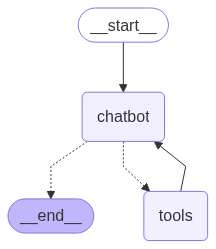

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
user_input = "You are a helpful assistant designed to search the files and folders required in a windows system.You have to do reasoning where you can find the particular file then take decision. First Use the FileManagement tool to list the files in the directory and if you find any folder related that  file then only provide the path or you have shell tool so open the file with shell tool dont ask just open it.You also have a human assistance tool if you need any help from human to find the file or folder. To open file you have the open file tool so give the full path of the file in windows format. Find profile pic, ask for me for help" 
config = {"configurable": {"thread_id": "6"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

You are a helpful assistant designed to search the files and folders required in a windows system.You have to do reasoning where you can find the particular file then take decision. First Use the FileManagement tool to list the files in the directory and if you find any folder related that  file then only provide the path or you have shell tool so open the file with shell tool dont ask just open it.You also have a human assistance tool if you need any help from human to find the file or folder. To open file you have the open file tool so give the full path of the file in windows format. Find profile pic, ask for me for help
================================== Ai Message ==================================
Tool Calls:
  list_directory (35kk8vcmw)
 Call ID: 35kk8vcmw
  Args:
    dir_path: Pictures
================================= Tool Message =================================
Name: list_directory

Error: [Wi

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `qwen/qwen3-32b` in organization `org_01j03cbythf6fs9ae5xeatt54e` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 8735, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [37]:
user_input = "what my last question ?"
events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what my last question ?
================================== Ai Message ==================================

Your last question was **"Find my the folder dblytics"**, and I located the `dblytics` folder on your desktop. I opened it for you using the system's default method. Let me know if you need further assistance with this folder or anything else! 😊


In [ ]:
human_response = (
    "not present here"

)
print("Human response:", human_response)
human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I have opened the "Saved Pictures" folder where profile pictures are commonly stored. Please check if your profile picture is located there. If not, I can search other common locations like Camera Roll or Desktop.


In [13]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os 
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")
# llm= ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)
llm= ChatGroq(model="qwen/qwen3-32b", api_key=api_key)

In [14]:
from langchain_community.tools import ShellTool

shell_tool = ShellTool()

from langchain_community.agent_toolkits import FileManagementToolkit
# 2. Initialize the FileManagementToolkit with your root directory
root_dir = "C:\\"
toolkit = FileManagementToolkit(root_dir=root_dir)
FileManagementTools = toolkit.get_tools()

In [14]:
# Debug your tool's expected input structure
print(FileManagementTools[6].args_schema.model_json_schema())
# print(FileManagementTools[2].description)

{'description': 'Input for ListDirectoryTool.', 'properties': {'dir_path': {'default': '.', 'description': 'Subdirectory to list.', 'title': 'Dir Path', 'type': 'string'}}, 'title': 'DirectoryListingInput', 'type': 'object'}


In [ ]:

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langgraph.types import interrupt
import os

memory = MemorySaver()
# @tool
# def human_assistance_tool(query: str) -> str:
#     """Ask human for assistance. Assitance can be asking like if file you are asking in which which folder from the given list"""
#     human_response = interrupt({"query": query})
#     return human_response["data"]

@tool
def open_file(file_path: str) -> None:
    """Give the full path of the file you want to open according to windows format"""
    os.startfile(file_path)
    return "done"

from langgraph.types import interrupt, Command
@tool
def human_feedback_node(state):
    # Extract relevant information from the state to present to the human
    message_to_human = state["messages"][-1].content if state["messages"] else "Please provide your input."
        
    # Interrupt the graph and prompt for human input
    human_input = interrupt({"message_for_human": message_to_human})
        
    # Process the human_input and update the state as needed
    # For example, you might add a HumanMessage to the messages list
    # or update other state variables based on the feedback.
    return {"human_feedback": human_input} # Example update

tools = [shell_tool,FileManagementTools[6],human_feedback_node, open_file]
agent = create_react_agent(llm, tools,prompt="You are a helpful assistant designed to search the files and folders required in a windows system.You have to do reasoning where you can find the particular file then take decision. First Use the FileManagement tool to list the files in the directory and if you find any folder related that  file then only provide the path or you have shell tool so open the file with shell tool dont ask just open it.You also have a human assistance tool if you need any help from human to find the file or folder. To open file you have the open file tool so give the full path of the file in windows format.",checkpointer=memory)

input_message = {
    "role": "user",
    "content": (
        "Open my profile image "
    ),
}

for step in agent.stream(
    {"messages": [input_message]},
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

TypeError: create_react_agent() got unexpected keyword arguments: {'checkpoint_saver': <langgraph.checkpoint.memory.InMemorySaver object at 0x000001967835E0D0>}

In [ ]:
from typing import Annotated

# from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

<>:2: SyntaxWarning: invalid escape sequence '\K'
<>:2: SyntaxWarning: invalid escape sequence '\K'
C:\Users\hp\AppData\Local\Temp\ipykernel_4268\803864800.py:2: SyntaxWarning: invalid escape sequence '\K'
  os.startfile("C:\KshitijDocs\profile.jpg")


In [79]:
# 8. Invoke the graph with an initial user message

initial_state = {
    "messages": [
        {"role": "user", "content": "Search for directory name containing the word 'Ai agents'."}
    ]
}
graph.invoke(initial_state, {"verbose": True})
# print(result["messages"][-1].content)

{'messages': [HumanMessage(content="Search for directory name containing the word 'Ai agents'.", additional_kwargs={}, response_metadata={}, id='2a246033-8215-4c67-a532-b5bc09fc648d'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to search for directory name containing the word \'Ai agents\'. Likely in the current workspace. Use file_search with pattern containing Ai agents. The pattern: maybe \'Ai agents\' with space. In regex, space is literal. Use pattern "Ai agents" or "Ai agents". Let\'s search.', 'tool_calls': [{'id': 'fc_f1646ac2-9619-4081-8c4b-b0f84eb1b31d', 'function': {'arguments': '{"dir_path":".","pattern":"Ai agents"}', 'name': 'file_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 396, 'total_tokens': 488, 'completion_time': 0.081768236, 'prompt_time': 0.025644767, 'queue_time': 0.046799643, 'total_time': 0.107413003}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_a5ac

In [77]:
result['messages'][-1].content

"I ran a recursive search for any file whose **name** contains the exact phrase “Ai agents” (case‑insensitive) and found none in the current directory tree.\n\nIf you’re looking for the phrase inside the *content* of files (e.g., a README, a source file, a markdown document, etc.), the tool set here only lets us inspect file names directly. To locate “Ai agents” inside file contents you would need to:\n\n1. **Manually inspect** the most likely candidates (e.g., README.md, .txt, .py, .ipynb files) by opening them in a text editor or using a command‑line tool such as `grep` on your local machine.\n2. **Use a script** that iterates over all files, reads each one, and searches for the string. For example, in Python you could do:\n\n   ```python\n   import pathlib, re\n\n   root = pathlib.Path('.')\n   pattern = re.compile(r'Ai\\s+agents', re.IGNORECASE)\n   for file in root.rglob('*'):\n       if file.is_file() and file.suffix in {'.md', '.txt', '.py', '.ipynb'}:\n           text = file.re